## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [1]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
from main.io import load_ml_data, load_bl_data
from main.verification import plot_verification 

In [2]:
# Configuration variables (You'll need to change based on where you store your data)
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
data_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so mode must be set to 'test' in load_ml_data or load_bl_data </div>

### Step 1. Load the ML and Baseline Testing Datasets

In [3]:
# Set the target column 
hazard='tornado' #Use tornado to get 0-2UH Baseline
scale='36km' #9,18,36
target_col=f'{hazard}_severe__{scale}'
# Set the mode == test so as to load the testing dataset. 
mode='test'
All=True #Flag for using all-severe as targets




if All: #Use all severe as target
    X,y,metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=f'wind_severe__{scale}',
                           FRAMEWORK=FRAMEWORK,
                           TIMESCALE=TIMESCALE)
    print(len(y[y>0]))
    for hazard in ['hail','tornado']: #tornado
        target_col='{}_severe__{}'.format(hazard, scale)
        SPAM, y1, SPAM  = load_ml_data(base_path=data_path, mode=mode, target_col=target_col, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE) 
        y +=y1
        print(len(y[y>0]))
       
    y[y > 0] = 1
else:
    X,y,metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=target_col)



# Load the testing dataset for the baseline model. 
# The baseline and machine learning models are 
# using the same target values so we do not need 
# initialize the baseline target values. 
bl_df, _, _ = load_bl_data(base_path=data_path, 
                             mode=mode, 
                             target_col=target_col, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE
                            )
bl_col = {'hail_severe' :  'hailcast__nmep_>1_25_45km',
          'wind_severe' : 'ws_80__nmep_>40_45km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>50_27km'
         } #Need to change this?


#36: 1_25, 45 | 40, 45 | 175, 45
#18: 1_25, 27 | 40, 27 | 200, 27
#9: 1_25, 27 | 40, 27 | 175, 9




# Get the X input into the baseline model. 
X_bl = bl_df[bl_col[target_col.split('__')[0]]]

50750
89607
94310


In [4]:
X=X.drop(['NX','NY'], axis=1)
original=False
envonly=False
intrastorm=False
vardic={ 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                    ]}
if original:
    print("Using Original Variables- Dropping IQR, 2nd lowest, 2nd highest, and intrastorm mean")
    X=X[[col for col in X.columns if 'IQR' not in col]]
    X=X[[col for col in X.columns if '2nd' not in col]]
    X=X[[col for col in X.columns if '16th' not in col]]
    #Mean of intrastorm vars
  
    badthings=np.array([])
    for strmvar in vardic['ENS_VARS']:
        badthings=np.append(badthings, [col for col in X.columns if 'mean' in col and strmvar in col] )

    X=X.drop(badthings, axis=1)
    
else:
    print("Using new variables- dropping old 90th percentile")
    X=X[[col for col in X.columns if '90th' not in col]] #Keeps all columns except the old 90th %ile
    
if envonly:
    print("Dropping all intrastorm variables")
    stormcols=np.array([])
    for strmvar in vardic['ENS_VARS']:
        stormcols=np.append(stormcols, [col for col in X.columns if strmvar in col]) #Every column name that has a storm var
    X=X.drop(stormcols, axis=1) #Drops all IS columns    
elif intrastorm:
    print("Dropping all env vars")
    stormcols=np.array([])
    for strmvar in vardic['ENS_VARS']:
        stormcols=np.append(stormcols, [col for col in X.columns if strmvar in col])
    X=X[stormcols]

Using new variables- dropping old 90th percentile


### Step 2. Load the ML and Baseline models. 

In [5]:
#base_path = f'/work/mflora/ML_2TO6HR/models/'
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'


# Load the ML model.
if intrastorm:
    ml_data = joblib.load(join(base_path, f'mlModels/isonly/Varga_all_hist_{hazard}_{scale}.joblib'))
    # Load the baseline model. 
    bl_model = joblib.load(join(base_path,f'blModels/{target_col.split("_")[0]}_baseline_model_{scale}.joblib'))
elif All:
    ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_all_hist_all_{scale}.joblib'))
    bl_model=joblib.load(join(base_path, f'blModels/all_baseline_model_{scale}.joblib'))
else:
    ml_data = joblib.load(join(base_path, f'mlModels/{scale}/{hazard}/Varga_all_hist_{hazard}_{scale}.joblib')) #First Model (Hist)
    # Load the baseline model. 
    bl_model = joblib.load(join(base_path,f'blModels/{target_col.split("_")[0]}_baseline_model_{scale}.joblib'))
# When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
# there are additional metadata that is stored with it. 
# We want to load the model and the features. 
# We want to make sure the X input as the features in correct order. 
ml_model = ml_data['model']
features = ml_data['features']

ml_models = [ml_model] 

for name in ['logistic','random','ADAM']: #Adds the Logistic and random models to the list
    #ml_data = joblib.load(join(base_path, f'mlModels/{scale}/{hazard}/Varga_all_{name}_{hazard}_{scale}.joblib'))
    ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_all_{name}_all_{scale}.joblib'))
    ml_model = ml_data['model']
    ml_models.append(ml_model)
    
names = ['Hist', 'Logistic', 'Random','ADAM'] 
estimators = [(name, model) for name, model in zip(names, ml_models)]

X = X[features]

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Step 3. Evaluate the ML and Baseline models using Reliability, Performance, and ROC Diagrams

/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shap

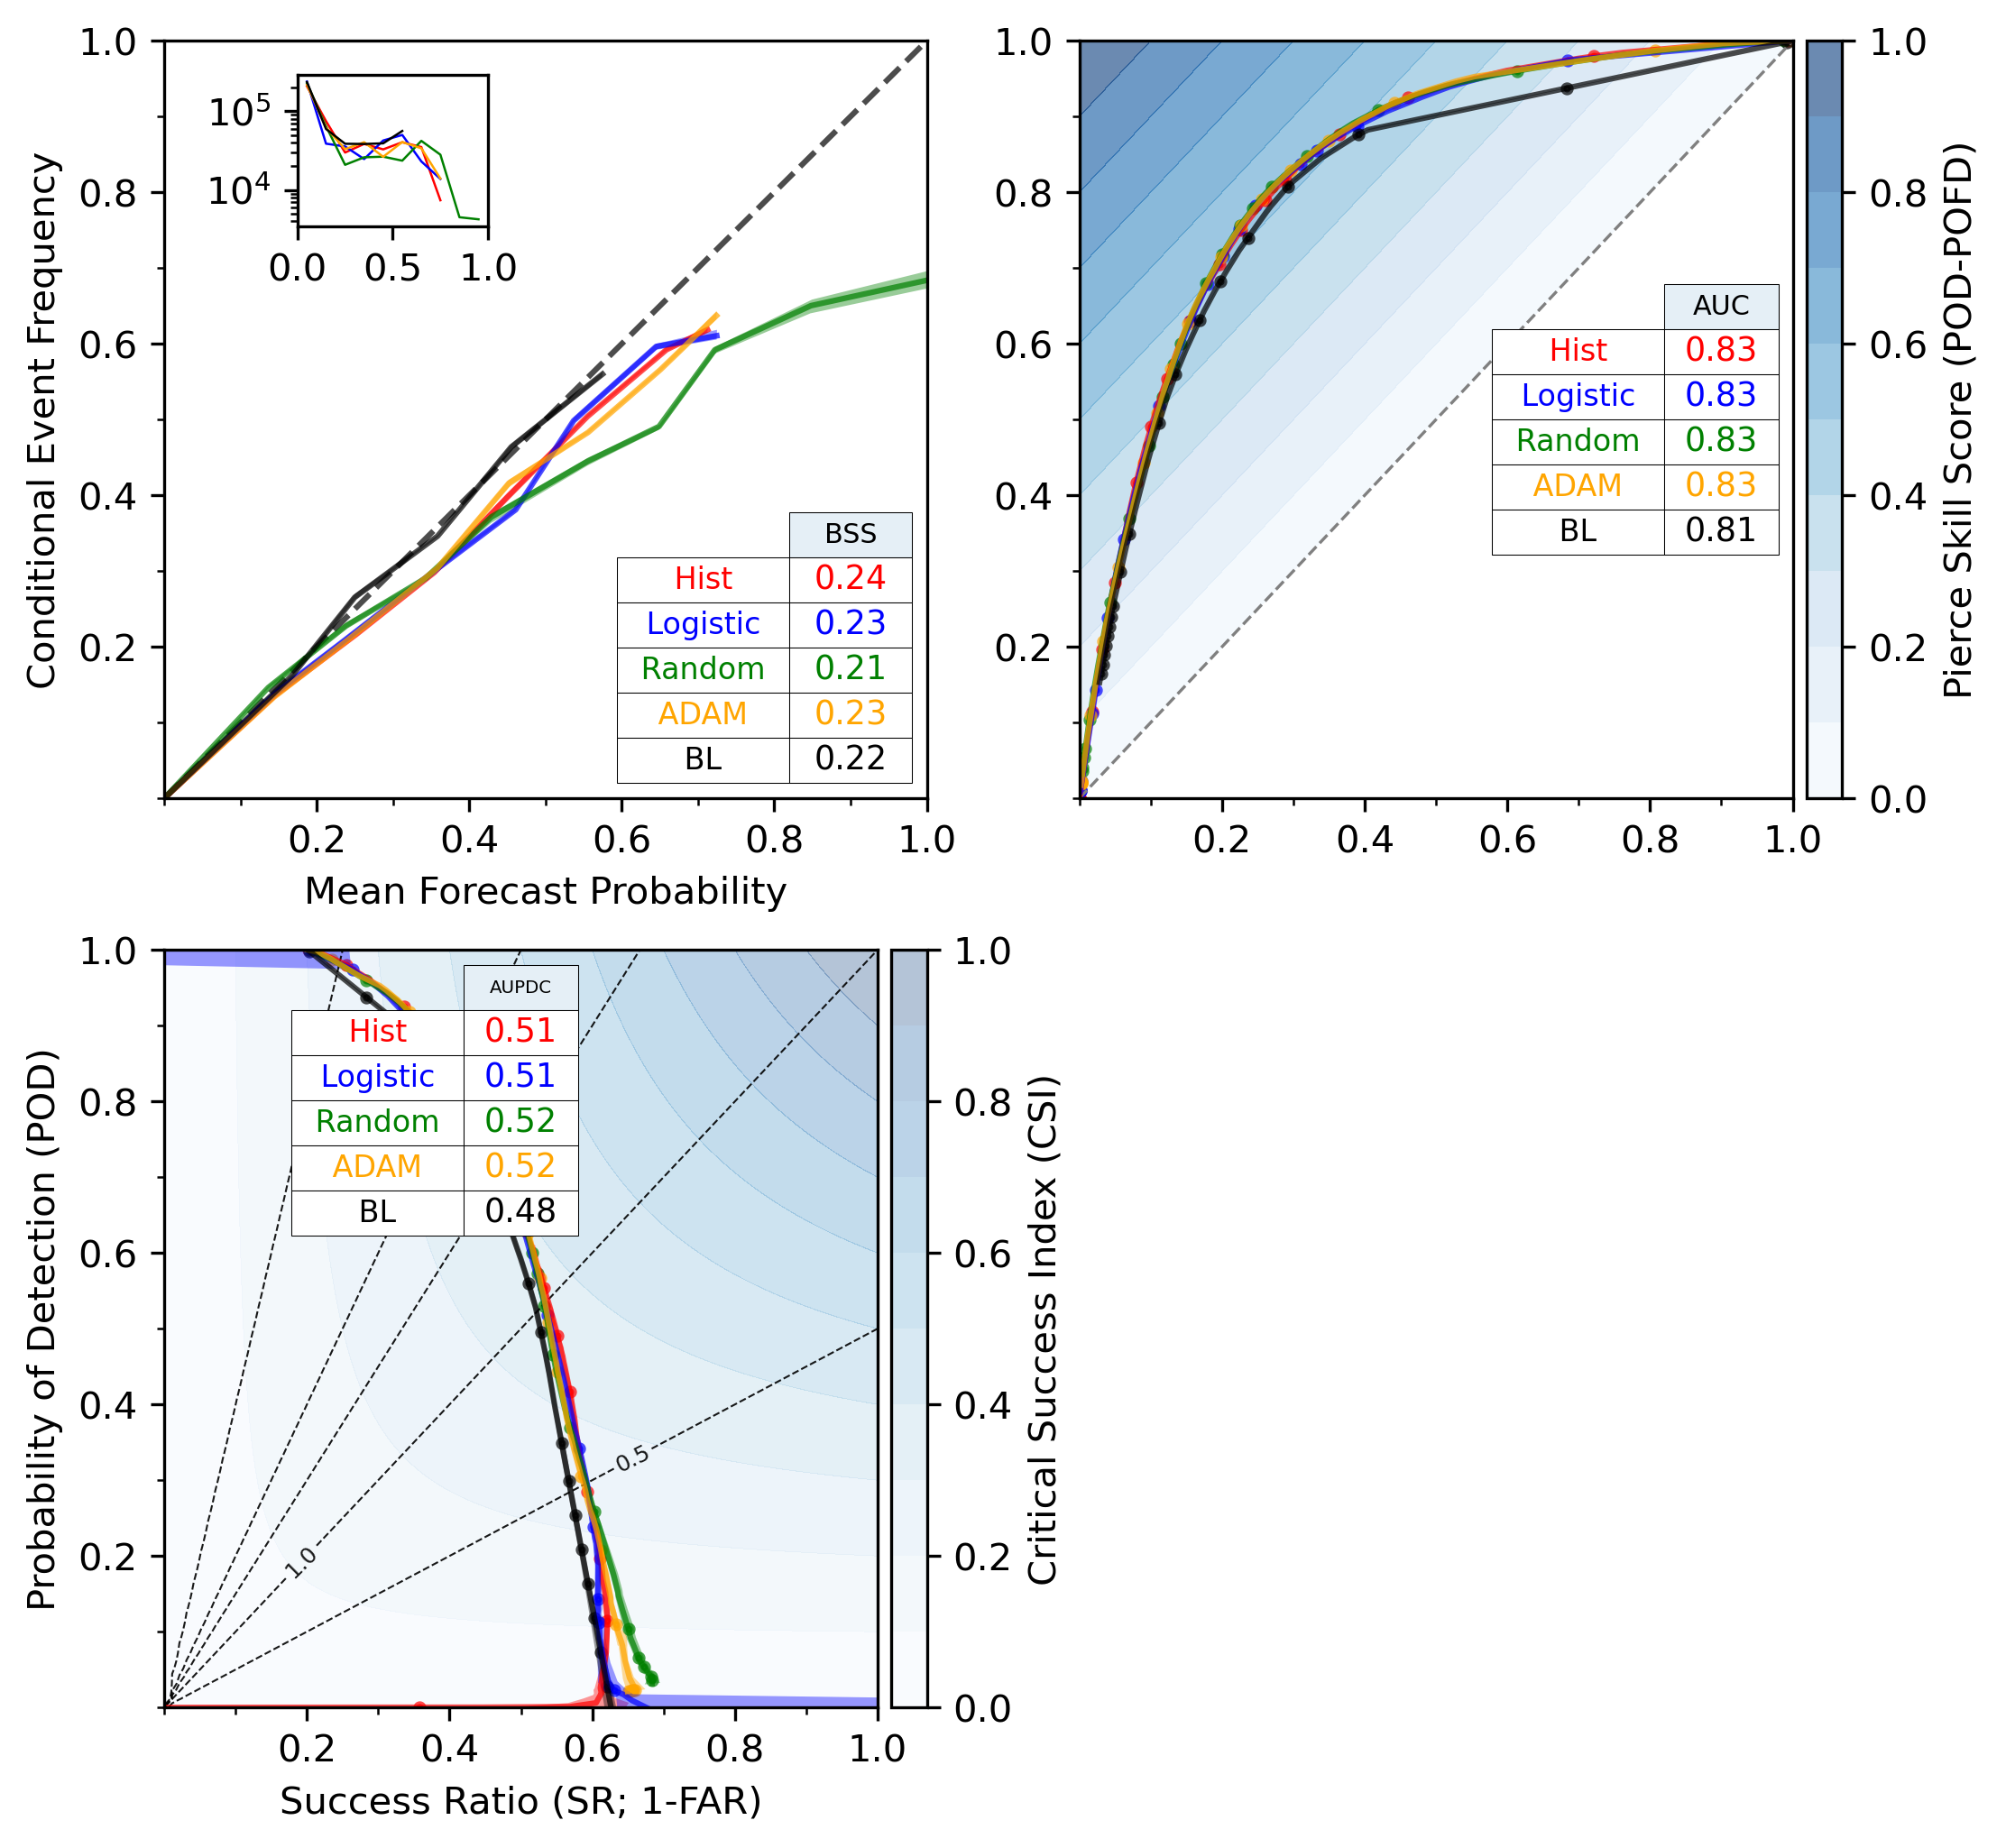

In [6]:
# Since X_bl and y are dataframe, we convert them to numpy.arrays 
# by using .values method. 
plot_verification(estimators = estimators, 
                  baseline_estimators = [('BL', bl_model)], 
                  X = X, 
                  X_baseline = X_bl.values, 
                  y=y.values,
                  n_boot=10
                 )

# Uncomment and modify the filename to save the figure. 
#plt.savefig(f'{target_col}.png')

In [7]:
print(np.mean(y))

0.20166187690307572
